In [1]:
from astropy.table import Table
import pandas as pd
from gaiaxpy import calibrate
from gaiaxpy import convert
import time
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import yaml
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from scipy.ndimage import gaussian_filter1d
import sys

In [2]:
def sycall(comand):
    import os
    linp=comand
    os.system(comand)

def retrive_gaia_star(gaiaID,gaia_dir=''):
    import os.path as ptt
    import requests
    if ptt.exists(gaia_dir+'/gaia_spec_'+str(gaiaID)+'.csv') == True:
        # read the tables from our cache
        gaiaflux = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+".csv",format="csv")
        gaiawave = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+"_sampling.csv",format="csv")
    else:
        # need to download from Gaia archive
        CSV_URL = 'https://gea.esac.esa.int/data-server/data?RETRIEVAL_TYPE=XP_CONTINUOUS&ID=Gaia+DR3+'+\
        str(gaiaID)+'&format=CSV&DATA_STRUCTURE=RAW'
        FILE = gaia_dir+'/XP_'+str(gaiaID)+'_RAW.csv'
        with open(FILE, 'w') as f, requests.get(CSV_URL, stream=True) as r:
            f.write(r.content.decode('utf-8'))
        # convert coefficients to sampled spectrum
        _, _ = calibrate(FILE, output_path=gaia_dir,output_file='gaia_spec_'+str(gaiaID),output_format='csv')
        # read the flux and wavelength tables
        gaiaflux = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+".csv",format="csv")
        gaiawave = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+"_sampling.csv",format="csv")
    # make numpy arrays from whatever weird objects the Gaia stuff creates
    wave = np.fromstring(gaiawave['pos'][0][1:-1],sep=',')*10# in Angstrom
    flux = 1e7*1e-1*1e-4*np.fromstring(gaiaflux['flux'][0][1:-1],sep=',')# W/s/micron -> in erg/s/cm^2/A
    return  flux,wave

    
    
def retrive_gaia_star_old(gaiaID,gaia_dir=''):
    import os.path as ptt
    if ptt.exists(gaia_dir+'/gaia_spec_'+str(gaiaID)+'.csv') == True:
        data1 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+".csv", format="csv")
        data2 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+"_sampling.csv", format="csv")
        flux = np.array(list(data1["flux"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
        wave = np.array(list(data2["pos"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
    else:
        if ptt.exists(gaia_dir+'/XP_'+str(gaiaID)+'_RAW.csv') == True:
            f = gaia_dir+'/XP_'+str(gaiaID)+'_RAW.csv'
            df = pd.read_csv(f) 
            calibrated_spectra, _ = calibrate(df)
            calibrated_spectra, _ = calibrate(f, output_path=gaia_dir, output_file='gaia_spec_'+str(gaiaID), output_format='csv')
            data1 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+".csv", format="csv")
            data2 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+"_sampling.csv", format="csv")
            flux = np.array(list(data1["flux"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
            wave = np.array(list(data2["pos"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
        else:
            call='curl -k -b cookies-datalink.txt "https://gea.esac.esa.int/data-server/data?RETRIEVAL_TYPE=XP_CONTINUOUS&ID=Gaia+DR3+'+str(gaiaID)+'&format=CSV&DATA_STRUCTURE=RAW" > '+gaia_dir+'/XP_'+str(gaiaID)+'_RAW.csv'
            sycall(call)
            time.sleep(2)
            f = gaia_dir+'/XP_'+str(gaiaID)+'_RAW.csv'
            df = pd.read_csv(f) 
            calibrated_spectra, _ = calibrate(df)
            calibrated_spectra, _ = calibrate(f, output_path=gaia_dir, output_file='gaia_spec_'+str(gaiaID), output_format='csv')
            data1 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+".csv", format="csv")
            data2 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+"_sampling.csv", format="csv")
            flux = np.array(list(data1["flux"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
            wave = np.array(list(data2["pos"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
    wave=wave*1e1
    flux=flux*1e2#1e7*1e-1*1e-4        
    return flux,wave

def read_airmass(file_name,dir='./'):
    wave=[]
    ext=[]
    f=open(file_name,'r')
    for line in f:
        data=list(line.replace('\n','').split(' '))
        wave.extend([float(data[0])])
        ext.extend([float(data[1])])
    wave=np.array(wave)
    ext=np.array(ext)
    nt=np.where(ext < 1)[0]
    wave=wave[nt]
    ext=ext[nt]
    return wave,ext

In [3]:
def median_a(x,lw=5,lower=10000,wave=[]):
    if len(wave) > 0:
        index=np.where(wave < lower)[0]
        index2=np.where(wave >= lower)[0]
        x1=np.copy(x)
        x=x[index]
    x_n=np.zeros(len(x))
    for i in range(0, len(x)):
        if i <= lw:
            x_d=x[0:lw]
            #x_d=reject_outliers(x_d)
            x_n[i]=np.nanmean(x_d)
        if i >= len(x)-lw:
            x_d=x[len(x)-lw:len(x)]
            #x_d=reject_outliers(x_d)
            x_n[i]=np.nanmean(x_d)
        if i > lw and i < len(x)-lw:
            x_d=x[i-lw:i+lw]
            #x_d=reject_outliers(x_d)
            x_n[i]=np.nanmean(x_d) 
    if len(wave) > 0:
        x1[index]=x_n
        x1[index2]=x_n[-1]
        x_n=x1
    return x_n

In [4]:
def retrive_lvm_calib(expnum,redux_dir='',defCalib=False,aperdir='',aptc=False,mjd='0000',redux_ver='0.1.1.dev0/1111/',basename='lvmCFrame-NAME.fits',path_lvmcore='',spid=0,fibid=[-1],cmid='b'):
    file=path_lvmcore+'/metrology/lvm_fiducial_fibermap.yaml'
    f=open(file,'r')
    fiber_map = yaml.safe_load(f)
    fiber_map=fiber_map['fibers']
    Std_n=[]
    Std_id=[]
    for i in range(0, len(fiber_map)):
        if 'standard' in fiber_map[i][4]:
            Std_n.extend([str(fiber_map[i][11])])
            Std_id.extend([str(fiber_map[i][0])])
    try:
        file=redux_dir+'/'+redux_ver+'/'+mjd+'/'+basename.replace('NAME',str(expnum))
        [rss, hdr0]=fits.getdata(file,'FLUX', header=True)
        hdr1=fits.getheader(file,0)
        crpix=hdr0["CRPIX1"]
        cdelt=hdr0["CDELT1"]
        crval=hdr0["CRVAL1"]    
        mod=1944
    except:
        file=redux_dir+'/'+redux_ver+'/'+mjd+'/ancillary/'+basename.replace('NAME',str(expnum)).replace('SPID',cmid+str(spid))
        [rss, hdr1]=fits.getdata(file,0, header=True)
        if aptc:
            filec=aperdir+'/lvm-apercorr-SPID.fits'.replace('SPID',cmid+str(spid))
            [rssc, hdrt]=fits.getdata(filec,0, header=True)
            nxa,nya=rssc.shape 
        crpix=hdr1["CRPIX1"]
        cdelt=hdr1["CDELT1"]
        crval=hdr1["CRVAL1"]
        mod=648
    nx,ny=rss.shape    
    if mod == 648 and aptc:
        if ny > nya:
            rss=rss[:,0:nya]
            ny=nya
        if ny < nya:
            rssc=rssc[:,0:ny]
        print(ny,nya)
        rss=rss*rssc
    wave=crval+cdelt*(np.arange(ny)+1-crpix)  
    
    Object_ra=float(hdr1['POSCIRA'])
    Object_dec=float(hdr1['POSCIDE'])
    Object_T0=str(hdr1['INTSTART'])
    Object_AM=float(hdr1['TESCIAM'])
    Object_expT=float(hdr1['EXPTIME'])

    
    gaia_ID=[]
    gaia_T=[]
    gaia_N=[]
    gaia_ra=[]
    gaia_dec=[]
    gaia_T0=[]
    gaia_T1=[]
    gaia_exp=[]
    keys=list(hdr1.keys())
    for i in range(0, len(keys)):
        for j in range(1, 16):
            if "STD"+str(j)+"FIB" in keys[i]:
                gaia_N.extend([str(hdr1[keys[i]])])
            if "STD"+str(j)+"ACQ" in  keys[i]:
                gaia_T.extend([str(hdr1[keys[i]])])
            if "STD"+str(j)+"ID" in  keys[i]:
                gaia_ID.extend([str(hdr1[keys[i]])])
            if "STD"+str(j)+"RA" in  keys[i]:
                gaia_ra.extend([str(hdr1[keys[i]])])
            if "STD"+str(j)+"DE" in  keys[i]:
                gaia_dec.extend([str(hdr1[keys[i]])])  
            if "STD"+str(j)+"T0" in  keys[i]:
                gaia_T0.extend([str(hdr1[keys[i]])])
            if "STD"+str(j)+"T1" in  keys[i]:
                gaia_T1.extend([str(hdr1[keys[i]])])        
            if "STD"+str(j)+"EXP" in  keys[i]:
                gaia_exp.extend([str(hdr1[keys[i]])])  
    gaiaF_ID=[]
    gaia_I=[]  
    gaia_Nf=[] 
    gaia_raf=[]
    gaia_decf=[]
    gaia_T0f=[]
    gaia_T1f=[]
    gaia_expf=[]   
    for i in range(0, 15):
        if "T" in  gaia_T[i]:
            gaiaF_ID.extend([gaia_ID[i]])
            gaia_I.extend([i])
            gaia_Nf.extend([gaia_N[i]])
            gaia_raf.extend([gaia_ra[i]])
            gaia_decf.extend([gaia_dec[i]])
            gaia_T0f.extend([gaia_T0[i]])
            gaia_T1f.extend([gaia_T1[i]])
            gaia_expf.extend([gaia_exp[i]])
    gaiaF_IDf=[]  
    gaia_If=[]
    gaiaF_Nf=[]
    gaiaF_raf=[]
    gaiaF_decf=[]
    gaiaF_T0f=[]
    gaiaF_T1f=[]
    gaiaF_expf=[]
    for i in range(0, len(gaia_Nf)):
        for j in range(0, len(Std_n)):
            if gaia_Nf[i] == Std_n[j]:
                if spid > 0:
                    if spid == 1:
                        if int(Std_id[j]) < 649:
                            gaia_If.extend([(int(Std_id[j])-1) % mod])
                            gaiaF_IDf.extend([gaiaF_ID[i]])
                            gaiaF_Nf.extend([gaia_Nf[i]])
                            gaiaF_raf.extend([gaia_raf[i]])
                            gaiaF_decf.extend([gaia_decf[i]])
                            gaiaF_T0f.extend([gaia_T0f[i]])
                            gaiaF_T1f.extend([gaia_T1f[i]]) 
                            gaiaF_expf.extend([gaia_expf[i]]) 
                    if spid == 2:
                        if int(Std_id[j]) > 648 and int(Std_id[j]) < 1297:
                            gaia_If.extend([(int(Std_id[j])-1) % mod])
                            gaiaF_IDf.extend([gaiaF_ID[i]])
                            gaiaF_Nf.extend([gaia_Nf[i]])
                            gaiaF_raf.extend([gaia_raf[i]])
                            gaiaF_decf.extend([gaia_decf[i]])
                            gaiaF_T0f.extend([gaia_T0f[i]])
                            gaiaF_T1f.extend([gaia_T1f[i]]) 
                            gaiaF_expf.extend([gaia_expf[i]])                             
                    if spid == 3:
                        if int(Std_id[j]) > 1296:
                            gaia_If.extend([(int(Std_id[j])-1) % mod])
                            gaiaF_IDf.extend([gaiaF_ID[i]])
                            gaiaF_Nf.extend([gaia_Nf[i]])    
                            gaiaF_raf.extend([gaia_raf[i]])
                            gaiaF_decf.extend([gaia_decf[i]])
                            gaiaF_T0f.extend([gaia_T0f[i]])
                            gaiaF_T1f.extend([gaia_T1f[i]]) 
                            gaiaF_expf.extend([gaia_expf[i]])             
                else:
                    gaia_If.extend([int(Std_id[j])-1])
                    gaiaF_IDf.extend([gaiaF_ID[i]])
                    gaiaF_Nf.extend([gaia_Nf[i]])
                    gaiaF_raf.extend([gaia_raf[i]])
                    gaiaF_decf.extend([gaia_decf[i]])
                    gaiaF_T0f.extend([gaia_T0f[i]])
                    gaiaF_T1f.extend([gaia_T1f[i]]) 
                    gaiaF_expf.extend([gaia_expf[i]]) 
    
    
    lco=EarthLocation(lat=-29.008999964*u.deg, lon=-70.688663912*u.deg, height=2800*u.m)   
    airmass=np.zeros(len(gaiaF_raf))
    wave_ext,k_ext=read_airmass('LVM_LVM160_KLAM.dat')
    kext=interp1d(wave_ext,k_ext,kind='linear',bounds_error=False)(wave*1e10)
    wave=wave*1e10
    rssT=np.copy(rss)
    for i in range(0, len(gaiaF_raf)):
        c=SkyCoord(float(gaiaF_raf[i]), float(gaiaF_decf[i]), unit="deg") 
        t=Time(gaiaF_T0f[i])
        stdT = c.transform_to(AltAz(obstime=t,location=lco))  
        airmass[i]=stdT.secz 
        
        flux_g,wave_g=retrive_gaia_star_old(gaiaF_IDf[i],gaia_dir='gaia')
        flux_g=interp1d(wave_g,flux_g,kind='linear',bounds_error=False)(wave)
        flux_g= gaussian_filter1d(flux_g, 50)
        raw_spec=10**(0.4*kext*airmass[i])*rss[gaia_If[i],:]/float(gaiaF_expf[i])
        raw_spec = gaussian_filter1d(raw_spec, 5)
        raw_spec[np.where(raw_spec < 0)]=np.nan
        raw_spec=median_a(raw_spec,lw=15)
        raw_spec=gaussian_filter1d(raw_spec, 100)
        rssT[gaia_If[i],:]=flux_g/raw_spec
    
    calibF=rssT[gaia_If,:]
    calibF=np.nanmean(calibF,axis=0)
    if defCalib:
        hdu_list = fits.open('SensF_v2.fits')
        table_hdu = hdu_list[1]
        table_data = table_hdu.data
        senf=table_data.field('SENSF')
        wavesf=table_data.field('WAVE')
        calibF=interp1d(wavesf,senf,kind='linear',bounds_error=False)(wave)*1e-10
    
    for i in range(0, len(rss[:,0])):
        raw_spec=rss[i,:]
        at=0
        for j in range(0, len(gaiaF_raf)):
            if i == gaia_If[j]:
                at=1
        if at == 0:
            raw_spec=10**(0.4*kext*Object_AM)*raw_spec/Object_expT*calibF#*1e7
            rss[i,:]=raw_spec
            #print(raw_spec)
                
        
    h2=fits.PrimaryHDU(rss)
    h_k=h2.header
    for i in range(0, len(keys)):
        h_k[keys[i]]=hdr1[keys[i]]
        h_k.comments[keys[i]]=hdr1.comments[keys[i]]
    h_k.update()
    hlist=fits.HDUList([h2])
    hlist.update_extend()
    file=redux_dir+'/'+redux_ver+'/'+mjd+'/'+basename.replace('CFrame-','FluxCFrame-').replace('NAME',str(expnum))
    hlist.writeto(file, overwrite=True)
        
    return  rss,calibF,wave,gaia_If
        

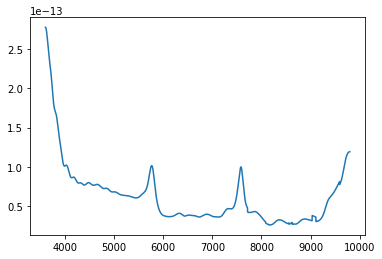

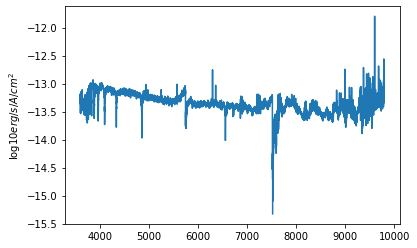

In [5]:
import sys
from astropy.io import fits

rss,lvm_spec,wave1,gaia_If=retrive_lvm_calib('00006570', path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60230',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')

#for i in range(0, len(gaiaF_ID)):
#    lvm_specF = lvm_spec[i,:]
#    plt.plot(wave1,lvm_specF)#/flux_1)#[index,:])
#    plt.ylabel('e-/s')

hdu_list = fits.open('SensF_v2.fits')
table_hdu = hdu_list[1]
table_data = table_hdu.data
senf=table_data.field('SENSF')
wave=table_data.field('WAVE')
plt.plot(wave1,lvm_spec)    
#plt.plot(wave,senf,lw=2,color='black')    
    
plt.show()

#lvm_spec = gaussian_filter1d(lvm_spec, 120)#120)
plt.plot(wave1,np.log10(rss[975,:]))#[index,:])
plt.ylabel('log10'+'$erg/s/A/cm^2$')
plt.show() 
